<a href="https://colab.research.google.com/github/pnvijay/pyimagesearch/blob/colab/bounding_box_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

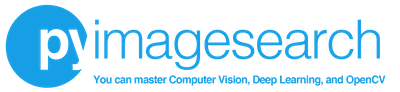

# Object detection: Bounding box regression with Keras, TensorFlow, and Deep Learning

### by [PyImageSearch.com](http://www.pyimagesearch.com)

## Welcome to **[PyImageSearch Plus](http://pyimg.co/plus)** Jupyter Notebooks!

This notebook is associated with the [Object detection: Bounding box regression with Keras, TensorFlow, and Deep Learning](http://pyimg.co/gk8s6) blog post published on 10-05-20.

Only the code for the blog post is here. Most codeblocks have a 1:1 relationship with what you find in the blog post with two exceptions: (1) Python classes are not separate files as they are typically organized with PyImageSearch projects, and (2) Command Line Argument parsing is replaced with an `args` dictionary that you can manipulate as needed.

We recommend that you execute (press ▶️) the code block-by-block, as-is, before adjusting parameters and `args` inputs. Once you've verified that the code is working, you are welcome to hack with it and learn from manipulating inputs, settings, and parameters. For more information on using Jupyter and Colab, please refer to these resources:

*   [Jupyter Notebook User Interface](https://jupyter-notebook.readthedocs.io/en/stable/notebook.html#notebook-user-interface)
*   [Overview of Google Colaboratory Features](https://colab.research.google.com/notebooks/basic_features_overview.ipynb)

As a reminder, these PyImageSearch Plus Jupyter Notebooks are not for sharing; please refer to the **Copyright** directly below and **Code License Agreement** in the last cell of this notebook. 

Happy hacking!

*Adrian*

<hr>

***Copyright:*** *The contents of this Jupyter Notebook, unless otherwise indicated, are Copyright 2020 Adrian Rosebrock, PyimageSearch.com. All rights reserved. Content like this is made possible by the time invested by the authors. If you received this Jupyter Notebook and did not purchase it, please consider making future content possible joining PyImageSearch Plus at [http://pyimg.co/plus/](http://pyimg.co/plus) today.*

### Install the necessary packages

In [1]:
!pip install tensorflow==2.2.0

     |████████████████████████████████| 516.2MB 33kB/s 
     |████████████████████████████████| 3.0MB 55.0MB/s 
     |████████████████████████████████| 460kB 54.4MB/s 
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0


### Download the code zip file

In [4]:
!nvidia-smi

Wed Oct  7 03:46:54 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
!wget https://s3-us-west-2.amazonaws.com/static.pyimagesearch.com/bounding-box-regression/bounding-box-regression.zip
!unzip -qq bounding-box-regression.zip
%cd bounding-box-regression

--2020-10-07 03:47:10--  https://s3-us-west-2.amazonaws.com/static.pyimagesearch.com/bounding-box-regression/bounding-box-regression.zip
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.218.218.128
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.218.218.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92430845 (88M) [application/zip]
Saving to: ‘bounding-box-regression.zip’

bounding-box-regres 100%[===================>]  88.15M  82.1MB/s    in 1.1s    

2020-10-07 03:47:11 (82.1 MB/s) - ‘bounding-box-regression.zip’ saved [92430845/92430845]

/content/bounding-box-regression


## Blog Post Code

### Import Packages

In [6]:
# import the necessary packages
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import mimetypes
import argparse
import imutils
import cv2
import os

### Function to display images in Jupyter Notebooks and Google Colab

In [7]:
def plt_imshow(title, image):
    # convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

### Define our `Config` class

In [8]:
class Config:
    # define the base path to the input dataset and then use it to derive
    # the path to the images directory and annotation CSV file
    BASE_PATH = "dataset"
    IMAGES_PATH = os.path.sep.join([BASE_PATH, "images"])
    ANNOTS_PATH = os.path.sep.join([BASE_PATH, "airplanes.csv"])

    # define the path to the base output directory
    BASE_OUTPUT = "output"

    # define the path to the output serialized model, model training plot,
    # and testing image filenames
    MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "detector.h5"])
    PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
    TEST_FILENAMES = os.path.sep.join([BASE_OUTPUT, "test_images.txt"])

    # initialize our initial learning rate, number of epochs to train
    # for, and the batch size
    INIT_LR = 1e-4
    NUM_EPOCHS = 25
    BATCH_SIZE = 32

# instantiate the config class
config = Config()

### Implementing our bounding box regression training script with Keras and TensorFlow

In [9]:
# load the contents of the CSV annotations file
print("[INFO] loading dataset...")
rows = open(config.ANNOTS_PATH).read().strip().split("\n")

# initialize the list of data (images), our target output predictions
# (bounding box coordinates), along with the filenames of the
# individual images
data = []
targets = []
filenames = []

[INFO] loading dataset...


In [10]:
rows[0]

'image_0001.jpg,49,30,349,137'

In [22]:
a = open(config.ANNOTS_PATH)
type(a)

_io.TextIOWrapper

In [13]:
a.read()

'image_0001.jpg,49,30,349,137\nimage_0002.jpg,59,35,342,153\nimage_0003.jpg,47,36,331,135\nimage_0004.jpg,47,24,342,141\nimage_0005.jpg,48,18,339,146\nimage_0006.jpg,48,24,344,126\nimage_0007.jpg,49,23,344,122\nimage_0008.jpg,51,29,344,119\nimage_0009.jpg,50,29,344,137\nimage_0010.jpg,55,32,335,106\nimage_0011.jpg,58,35,344,130\nimage_0012.jpg,49,25,344,122\nimage_0013.jpg,48,31,344,146\nimage_0014.jpg,55,37,349,121\nimage_0015.jpg,61,39,353,163\nimage_0016.jpg,59,54,327,137\nimage_0017.jpg,62,37,347,143\nimage_0018.jpg,57,33,348,147\nimage_0019.jpg,51,33,341,146\nimage_0020.jpg,45,31,345,165\nimage_0021.jpg,48,28,347,129\nimage_0022.jpg,49,30,344,130\nimage_0023.jpg,50,23,341,121\nimage_0024.jpg,48,25,344,106\nimage_0025.jpg,56,31,342,140\nimage_0026.jpg,59,30,337,127\nimage_0027.jpg,53,25,348,123\nimage_0028.jpg,54,29,346,114\nimage_0029.jpg,56,29,348,119\nimage_0030.jpg,47,15,354,161\nimage_0031.jpg,58,41,347,197\nimage_0032.jpg,50,29,342,119\nimage_0033.jpg,49,29,339,133\nimage_003

In [20]:
a.read().strip()

'image_0001.jpg,49,30,349,137\nimage_0002.jpg,59,35,342,153\nimage_0003.jpg,47,36,331,135\nimage_0004.jpg,47,24,342,141\nimage_0005.jpg,48,18,339,146\nimage_0006.jpg,48,24,344,126\nimage_0007.jpg,49,23,344,122\nimage_0008.jpg,51,29,344,119\nimage_0009.jpg,50,29,344,137\nimage_0010.jpg,55,32,335,106\nimage_0011.jpg,58,35,344,130\nimage_0012.jpg,49,25,344,122\nimage_0013.jpg,48,31,344,146\nimage_0014.jpg,55,37,349,121\nimage_0015.jpg,61,39,353,163\nimage_0016.jpg,59,54,327,137\nimage_0017.jpg,62,37,347,143\nimage_0018.jpg,57,33,348,147\nimage_0019.jpg,51,33,341,146\nimage_0020.jpg,45,31,345,165\nimage_0021.jpg,48,28,347,129\nimage_0022.jpg,49,30,344,130\nimage_0023.jpg,50,23,341,121\nimage_0024.jpg,48,25,344,106\nimage_0025.jpg,56,31,342,140\nimage_0026.jpg,59,30,337,127\nimage_0027.jpg,53,25,348,123\nimage_0028.jpg,54,29,346,114\nimage_0029.jpg,56,29,348,119\nimage_0030.jpg,47,15,354,161\nimage_0031.jpg,58,41,347,197\nimage_0032.jpg,50,29,342,119\nimage_0033.jpg,49,29,339,133\nimage_003

In [23]:
a.read().strip().split('\n')

['image_0001.jpg,49,30,349,137',
 'image_0002.jpg,59,35,342,153',
 'image_0003.jpg,47,36,331,135',
 'image_0004.jpg,47,24,342,141',
 'image_0005.jpg,48,18,339,146',
 'image_0006.jpg,48,24,344,126',
 'image_0007.jpg,49,23,344,122',
 'image_0008.jpg,51,29,344,119',
 'image_0009.jpg,50,29,344,137',
 'image_0010.jpg,55,32,335,106',
 'image_0011.jpg,58,35,344,130',
 'image_0012.jpg,49,25,344,122',
 'image_0013.jpg,48,31,344,146',
 'image_0014.jpg,55,37,349,121',
 'image_0015.jpg,61,39,353,163',
 'image_0016.jpg,59,54,327,137',
 'image_0017.jpg,62,37,347,143',
 'image_0018.jpg,57,33,348,147',
 'image_0019.jpg,51,33,341,146',
 'image_0020.jpg,45,31,345,165',
 'image_0021.jpg,48,28,347,129',
 'image_0022.jpg,49,30,344,130',
 'image_0023.jpg,50,23,341,121',
 'image_0024.jpg,48,25,344,106',
 'image_0025.jpg,56,31,342,140',
 'image_0026.jpg,59,30,337,127',
 'image_0027.jpg,53,25,348,123',
 'image_0028.jpg,54,29,346,114',
 'image_0029.jpg,56,29,348,119',
 'image_0030.jpg,47,15,354,161',
 'image_00

In [24]:
# loop over the rows
for row in rows:
	# break the row into the filename and bounding box coordinates
	row = row.split(",")
	(filename, startX, startY, endX, endY) = row

	# derive the path to the input image, load the image (in OpenCV
	# format), and grab its dimensions
	imagePath = os.path.sep.join([config.IMAGES_PATH, filename])
	image = cv2.imread(imagePath)
	(h, w) = image.shape[:2]

	# scale the bounding box coordinates relative to the spatial
	# dimensions of the input image
	startX = float(startX) / w
	startY = float(startY) / h
	endX = float(endX) / w
	endY = float(endY) / h

	# load the image and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)

	# update our list of data, targets, and filenames
	data.append(image)
	targets.append((startX, startY, endX, endY))
	filenames.append(filename)

In [25]:
# convert the data and targets to NumPy arrays, scaling the input
# pixel intensities from the range [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0
targets = np.array(targets, dtype="float32")

# partition the data into training and testing splits using 90% of
# the data for training and the remaining 10% for testing
split = train_test_split(data, targets, filenames, test_size=0.10,
	random_state=42)

# unpack the data split
(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]
(trainFilenames, testFilenames) = split[4:]

# write the testing filenames to disk so that we can use then
# when evaluating/testing our bounding box regressor
print("[INFO] saving testing filenames...")
f = open(config.TEST_FILENAMES, "w")
f.write("\n".join(testFilenames))
f.close()

[INFO] saving testing filenames...


In [27]:
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False

# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)

# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)

# construct the model we will fine-tune for bounding box regression
model = Model(inputs=vgg.input, outputs=bboxHead)

In [28]:
# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(lr=config.INIT_LR)
model.compile(loss="mse", optimizer=opt)
print(model.summary())

# train the network for bounding box regression
print("[INFO] training bounding box regressor...")
H = model.fit(
	trainImages, trainTargets,
	validation_data=(testImages, testTargets),
	batch_size=config.BATCH_SIZE,
	epochs=config.NUM_EPOCHS,
	verbose=1)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

[INFO] saving object detector model...


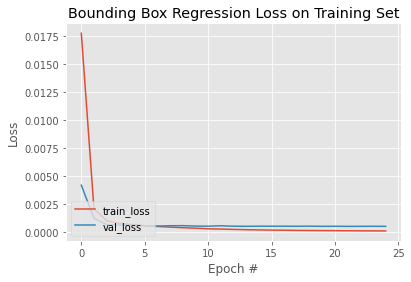

In [29]:
# serialize the model to disk
print("[INFO] saving object detector model...")
model.save(config.MODEL_PATH, save_format="h5")

# plot the model training history
N = config.NUM_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.show()

### Implementing our bounding box predictor with Keras and TensorFlow

In [30]:
# # construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--input", required=True,
# 	help="path to input image/text file of image filenames")
# args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
    "input": "output/test_images.txt"
}

In [31]:
# determine the input file type, but assume that we're working with
# single input image
filetype = mimetypes.guess_type(args["input"])[0]
imagePaths = [args["input"]]

# if the file type is a text file, then we need to process *multiple*
# images
if "text/plain" == filetype:
	# load the filenames in our testing file and initialize our list
	# of image paths
	filenames = open(args["input"]).read().strip().split("\n")
	imagePaths = []

	# loop over the filenames
	for f in filenames:
		# construct the full path to the image filename and then
		# update our image paths list
		p = os.path.sep.join([config.IMAGES_PATH, f])
		imagePaths.append(p)

[INFO] loading object detector...


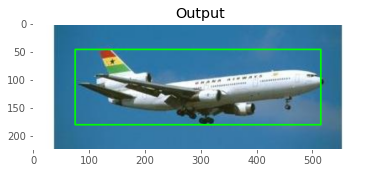

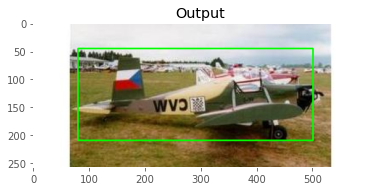

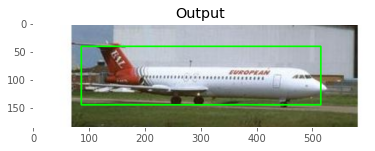

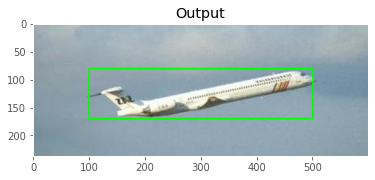

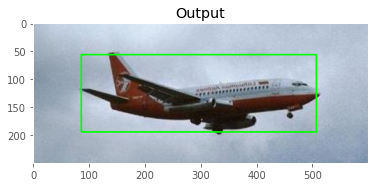

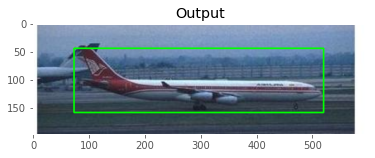

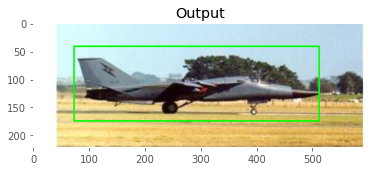

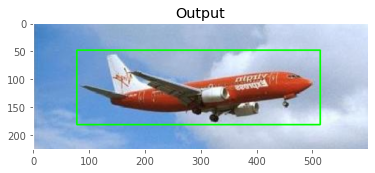

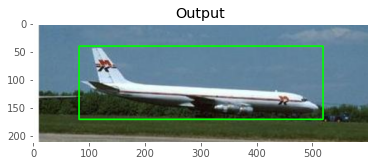

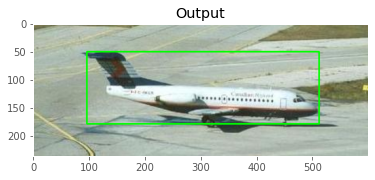

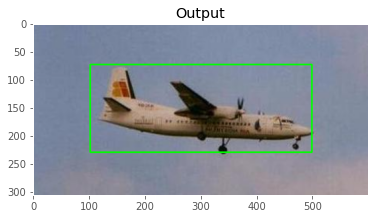

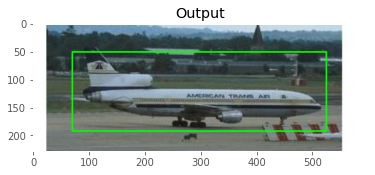

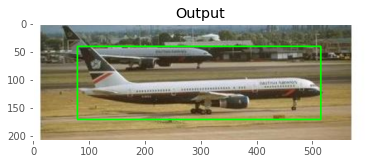

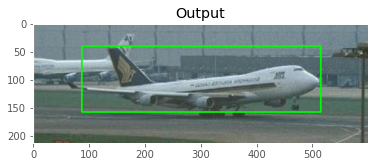

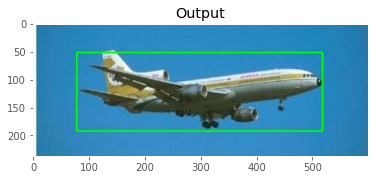

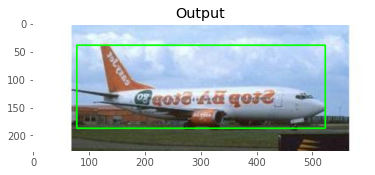

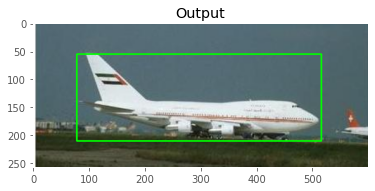

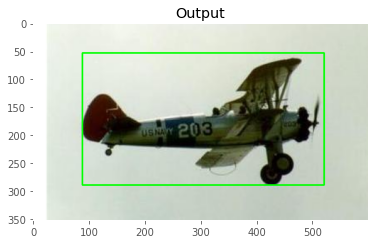

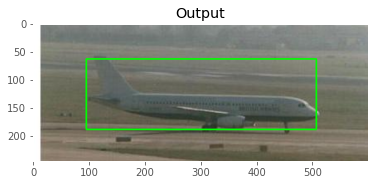

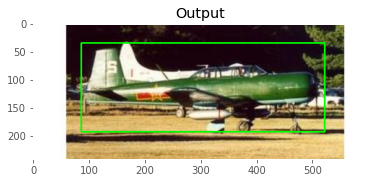

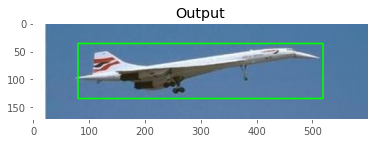

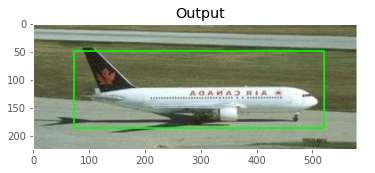

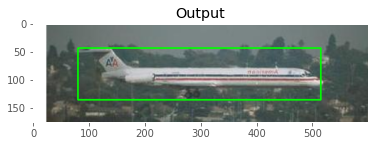

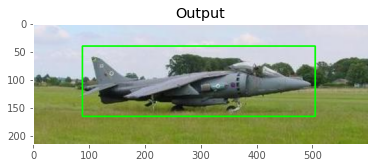

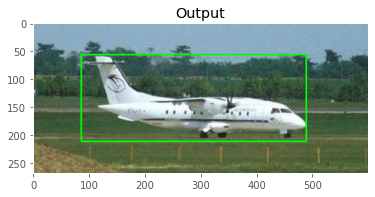

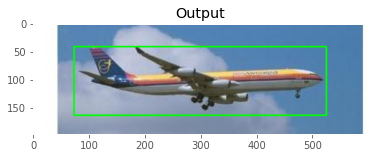

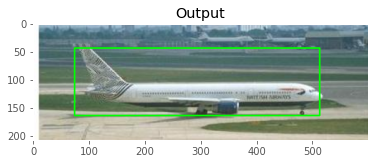

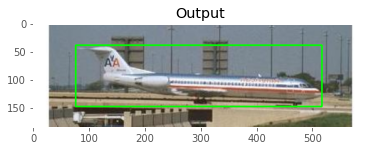

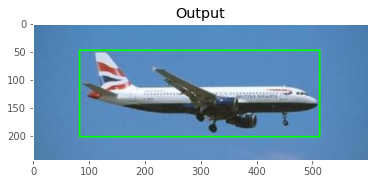

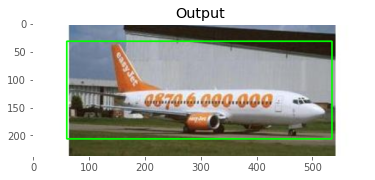

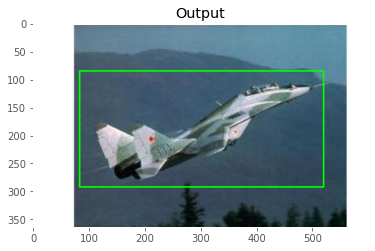

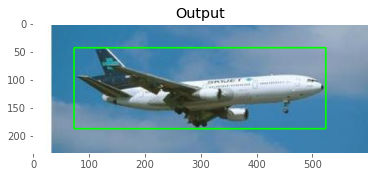

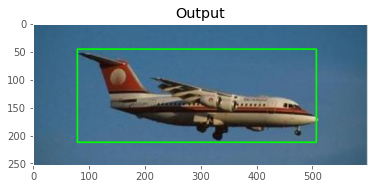

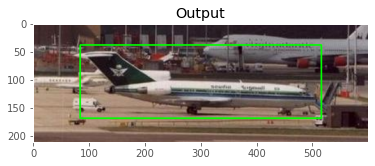

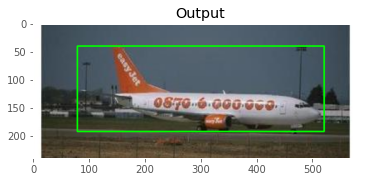

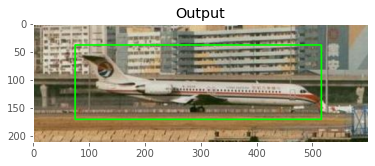

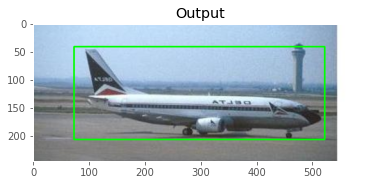

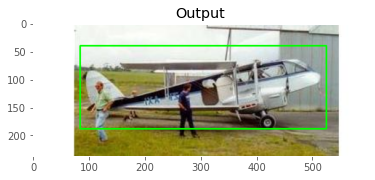

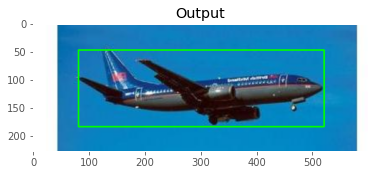

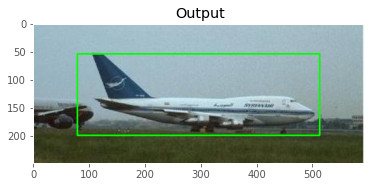

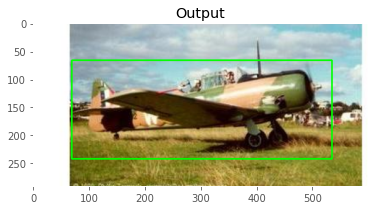

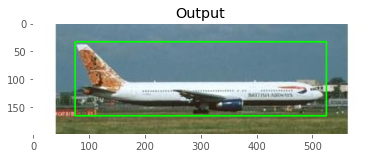

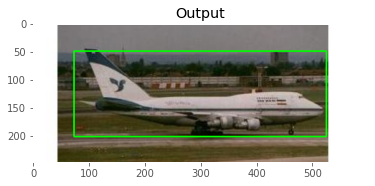

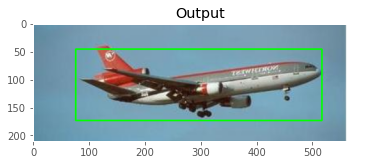

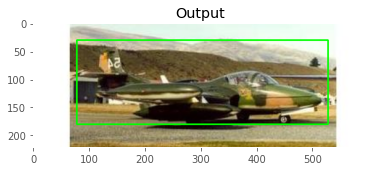

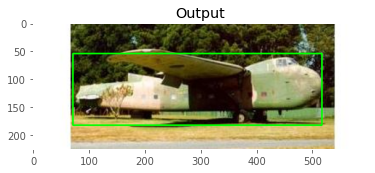

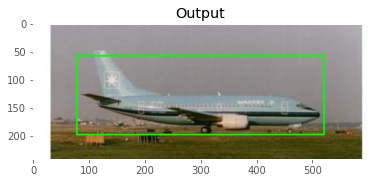

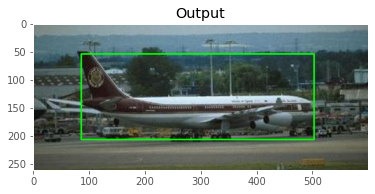

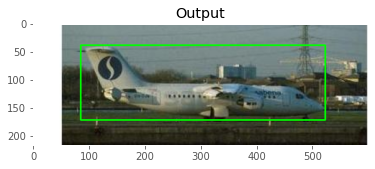

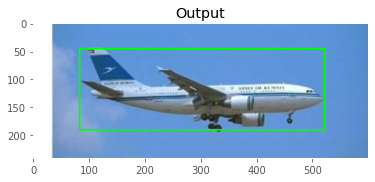

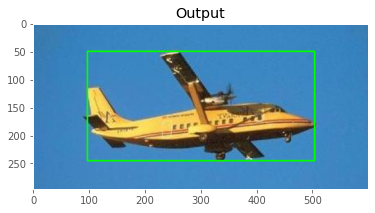

In [32]:
# load our trained bounding box regressor from disk
print("[INFO] loading object detector...")
model = load_model(config.MODEL_PATH)

# loop over the images that we'll be testing using our bounding box
# regression model
for imagePath in imagePaths:
	# load the input image (in Keras format) from disk and preprocess
	# it, scaling the pixel intensities to the range [0, 1]
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image) / 255.0
	image = np.expand_dims(image, axis=0)

	# make bounding box predictions on the input image
	preds = model.predict(image)[0]
	(startX, startY, endX, endY) = preds

	# load the input image (in OpenCV format), resize it such that it
	# fits on our screen, and grab its dimensions
	image = cv2.imread(imagePath)
	image = imutils.resize(image, width=600)
	(h, w) = image.shape[:2]

	# scale the predicted bounding box coordinates based on the image
	# dimensions
	startX = int(startX * w)
	startY = int(startY * h)
	endX = int(endX * w)
	endY = int(endY * h)

	# draw the predicted bounding box on the image
	cv2.rectangle(image, (startX, startY), (endX, endY),
		(0, 255, 0), 2)

	# show the output image
	plt_imshow("Output", image)

For a detailed walkthrough of the concepts and code, be sure to refer to the full tutorial, [*Object detection: Bounding box regression with Keras, TensorFlow, and Deep Learning*](http://pyimg.co/gk8s6) blog post published on 10-05-20.

# Code License Agreement
```
Copyright (c) 2020 PyImageSearch.com

SIMPLE VERSION
Feel free to use this code for your own projects, whether they are
purely educational, for fun, or for profit. THE EXCEPTION BEING if
you are developing a course, book, or other educational product.
Under *NO CIRCUMSTANCE* may you use this code for your own paid
educational or self-promotional ventures without written consent
from Adrian Rosebrock and PyImageSearch.com.

LONGER, FORMAL VERSION
Permission is hereby granted, free of charge, to any person obtaining
a copy of this software and associated documentation files
(the "Software"), to deal in the Software without restriction,
including without limitation the rights to use, copy, modify, merge,
publish, distribute, sublicense, and/or sell copies of the Software,
and to permit persons to whom the Software is furnished to do so,
subject to the following conditions:
The above copyright notice and this permission notice shall be
included in all copies or substantial portions of the Software.
Notwithstanding the foregoing, you may not use, copy, modify, merge,
publish, distribute, sublicense, create a derivative work, and/or
sell copies of the Software in any work that is designed, intended,
or marketed for pedagogical or instructional purposes related to
programming, coding, application development, or information
technology. Permission for such use, copying, modification, and
merger, publication, distribution, sub-licensing, creation of
derivative works, or sale is expressly withheld.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND,
EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES
OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS
BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN
ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
```